# Task 2: CLAIM/REF vs CONTEXT Classification

This notebook implements a machine learning pipeline for classifying scientific tweets as CLAIM/REF or CONTEXT.

In [7]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, make_scorer
)
import optuna
import emoji
import re
import scipy.sparse
import spacy
from langdetect import detect
import joblib


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


import os

# Création d'un répertoire local au cas où les chemins par défaut posent problème
nltk_data_dir = os.path.join(os.getcwd(), "nltk_data")
os.makedirs(nltk_data_dir, exist_ok=True)

# Ajout manuel au chemin
nltk.data.path.append(nltk_data_dir)

# Téléchargements des ressources nécessaires dans le bon répertoire
nltk.download("punkt", download_dir=nltk_data_dir)
nltk.download("stopwords", download_dir=nltk_data_dir)
nltk.download("wordnet", download_dir=nltk_data_dir)



#Librairies d'affichage
from PIL import Image  # Gestion et manipulation d'images
import plotly.graph_objs as go  # Création de graphiques personnalisés avec Plotly
import plotly.offline as py  # Mode offline pour afficher les graphiques Plotly
import plotly.express as px  # Visualisation simplifiée et rapide avec Plotly
import plotly.io as pio # Permet de sauvegarder l'image

#Librairies Scikit-learn
from sklearn.manifold import TSNE  # Réduction de dimensions avec T-SNE
from sklearn.decomposition import PCA  # Réduction de dimensions avec ACP

#Librairies UMAP
import umap.plot  # Visualisation des résultats de réduction de dimensions avec UMAP
from umap import UMAP  # Réduction de dimensions avec UMAP


[nltk_data] Downloading package punkt to /home/daniel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/daniel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/daniel/Bureau/ML/Machin
[nltk_data]     e_learning/Projet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/daniel/Bureau/ML/Ma
[nltk_data]     chine_learning/Projet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/daniel/Bureau/ML/Mach
[nltk_data]     ine_learning/Projet/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## InitialPipeline 

Pipeline for data exploring

In [8]:

class InitialDataLoader:
    def __init__(self, filepath):
        self.filepath = filepath
        self.df = None

    def load_data(self):
        self.df = pd.read_csv(self.filepath, sep='\t')
        print("\n📊 Aperçu du dataset :")
        display(self.df.head())
        print("Nombre total de lignes :", len(self.df))
        return self.df

    def filter_scientific_rows(self):
        df_sci = self.df[self.df["science_related"] == 1]
        print("Nombre de lignes scientifiques :", len(df_sci))
        return df_sci

    def visualize_distribution(self, df_sci):
        df_context = df_sci[df_sci["scientific_context"] == 1.0]
        df_context_unic = df_context[(df_context["scientific_claim"] == 0.0) & (df_context["scientific_reference"] == 0.0)]
        df_claim_ref = df_sci[(df_sci["scientific_claim"] == 1.0) & (df_sci["scientific_reference"] == 1.0)]
        df_claim_ou_ref = df_sci[(df_sci["scientific_claim"] == 1.0) | (df_sci["scientific_reference"] == 1.0)]
        df_claim_ou_ref_unic = df_claim_ou_ref[df_claim_ou_ref["scientific_context"] == 0.0]
        df_claim_ref_context = df_sci[(df_sci["scientific_claim"] == 1.0) & (df_sci["scientific_reference"] == 1.0) & (df_sci["scientific_context"] == 1.0)]

        print("\n📊 Répartition des données :")
        print("CLAIM et REF uniquement (sans context) :", len(df_claim_ref[(df_claim_ref["scientific_context"] == 0.0)]))
        print("CLAIM et REF (avec context possible) :", len(df_claim_ref))
        print("CLAIM ou REF (avec context) :", len(df_claim_ou_ref))
        print("CLAIM ou REF (sans context) :", len(df_claim_ou_ref_unic))
        print("CONTEXT uniquement (sans claim ou ref) :", len(df_context_unic))
        print("CONTEXT (avec claim ou ref)  :", len(df_context))
        print("CLAIM et REF et CONTEXT :", len(df_claim_ref_context))

        counts = {
            "CLAIM ou REF (avec context possible) ": len(df_claim_ou_ref),
            "CLAIM ou REF (sans context) ": len(df_claim_ou_ref_unic),
            "CONTEXT uniquement (sans claim ou ref) :": len(df_context_unic),
            "CONTEXT (avec claim ou ref)  :": len(df_context),
            "CLAIM et REF et CONTEXT :": len(df_claim_ref_context)
        }

        df_counts = pd.DataFrame(list(counts.items()), columns=["Catégorie", "Nombre"])

        plt.figure(figsize=(11, 7))
        bars = plt.bar(df_counts["Catégorie"], df_counts["Nombre"], 
                        color=["#4C72B0", "#55A868", "#C44E52", "#8172B3", "pink"])
        plt.title("Répartition des types d'assertions scientifiques", fontsize=14)
        plt.xlabel("Type d'assertion", fontsize=12)
        plt.ylabel("Nombre de tweets", fontsize=12)
        plt.xticks(rotation=15)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontsize=10)
        plt.tight_layout()
        plt.show()

    def plot_combination_pie(self):
        df = self.df.copy()
        df = df[~((df["scientific_claim"] == 0.0) & (df["scientific_reference"] == 0.0) & (df["scientific_context"] == 0.0))]
        combinations = df[["scientific_claim", "scientific_reference", "scientific_context"]].value_counts()
        combinations.index = combinations.index.map(lambda x: f"Claim={int(x[0])}, Ref={int(x[1])}, Context={int(x[2])}")
        plt.figure(figsize=(8, 8))
        combinations.plot(kind='pie', autopct='%1.1f%%', startangle=90, ylabel='',
                          title='Répartition des combinaisons CLAIM / REF / CONTEXT', fontsize=11)
        plt.tight_layout()
        plt.show()


📊 Aperçu du dataset :


,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


Nombre total de lignes : 1140
Nombre de lignes scientifiques : 375

📊 Répartition des données :
CLAIM et REF uniquement (sans context) : 0
CLAIM et REF (avec context possible) : 124
CLAIM ou REF (avec context) : 342
CLAIM ou REF (sans context) : 124
CONTEXT uniquement (sans claim ou ref) : 33
CONTEXT (avec claim ou ref)  : 251
CLAIM et REF et CONTEXT : 124


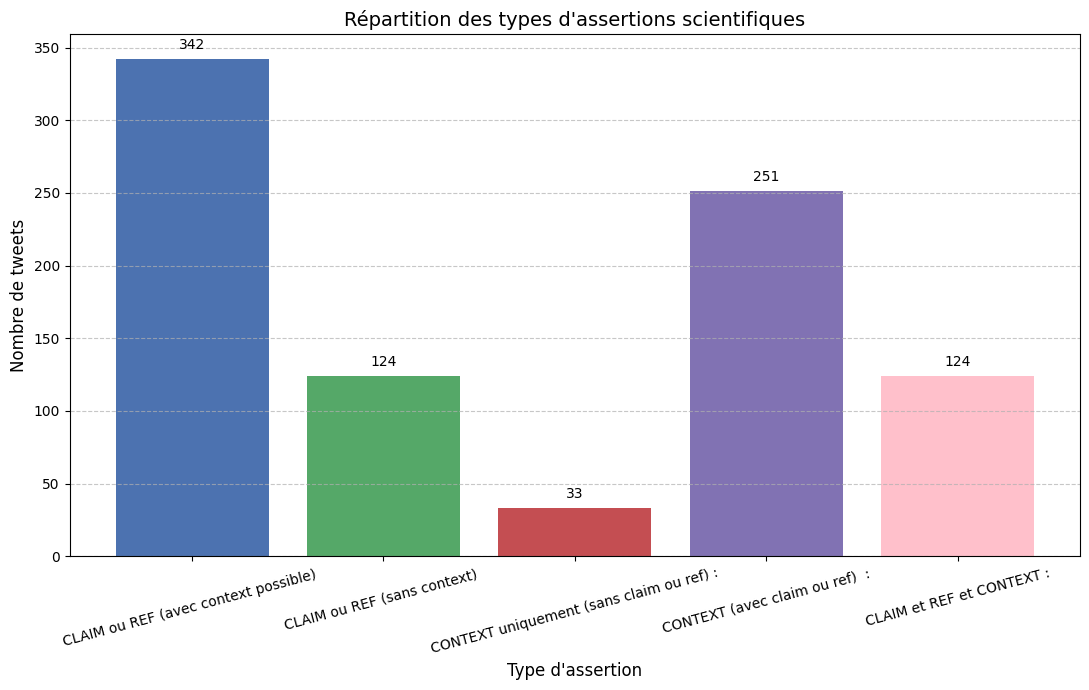

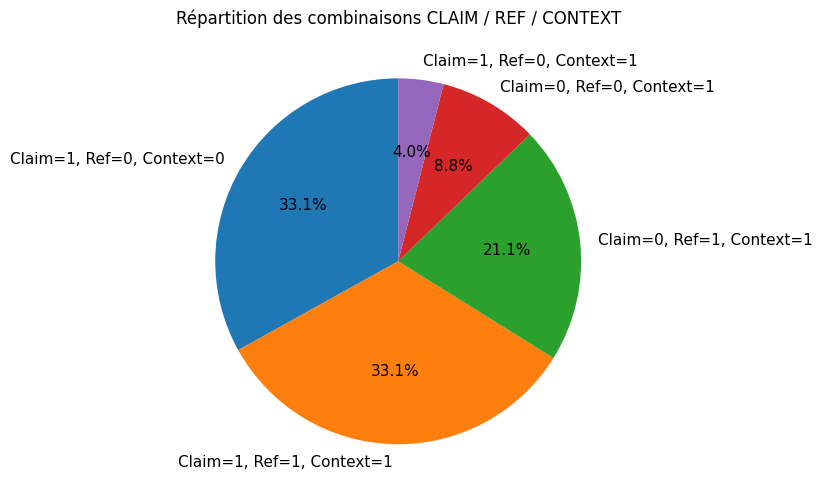

In [9]:

loader = InitialDataLoader("scitweets_export.tsv")
df = loader.load_data()
df_sci = loader.filter_scientific_rows()
loader.visualize_distribution(df_sci)
loader.plot_combination_pie()


## ModelPipeline Class Definition

Pipeline for data processing and model training

In [10]:
class ModelPipeline:
    def __init__(self, name="ModelPipeline"):
        self.name = name
        self.models = {
            "Logistic Regression": LogisticRegression(max_iter=500),
            "Naïve Bayes": MultinomialNB(),
            "Random Forest": RandomForestClassifier(),
            "SVM": SVC(),
            "SVM linear": LinearSVC(),
            "KNN": KNeighborsClassifier(),
            "AdaBoost": AdaBoostClassifier(),
            "Gradient Boosting": GradientBoostingClassifier(random_state=42),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            "Neural Network - MLP": MLPClassifier(max_iter=300)
        }
        self.scorers = {
            "Accuracy": make_scorer(accuracy_score),
            "Precision": make_scorer(precision_score),
            "Recall": make_scorer(recall_score),
            "F1 Score": make_scorer(f1_score)
        }
        self.results = {}
        self.best_model = None
        self.vectorizer = None

    def analyze_data(self, df):
        df_sci = df[df["science_related"] == 1]

        df_context = df_sci[df_sci["scientific_context"] == 1.0]
        df_context_unic = df_context[(df_context["scientific_claim"] == 0.0) & (df_context["scientific_reference"] == 0.0)]
        df_claim_ref = df_sci[(df_sci["scientific_claim"] == 1.0) & (df_sci["scientific_reference"] == 1.0)]
        df_claim_ou_ref = df_sci[(df_sci["scientific_claim"] == 1.0) | (df_sci["scientific_reference"] == 1.0)]
        df_claim_ou_ref_unic = df_claim_ou_ref[df_claim_ou_ref["scientific_context"] == 0.0]
        df_claim_ref_context = df_sci[
            (df_sci["scientific_claim"] == 1.0) & 
            (df_sci["scientific_reference"] == 1.0) & 
            (df_sci["scientific_context"] == 1.0)
        ]

        counts = {
            "CLAIM ou REF (avec context possible)": len(df_claim_ou_ref),
            "CLAIM ou REF (sans context)": len(df_claim_ou_ref_unic),
            "CONTEXT uniquement (sans claim ou ref)": len(df_context_unic),
            "CONTEXT (avec claim ou ref)": len(df_context),
            "CLAIM et REF et CONTEXT": len(df_claim_ref_context)
        }

        df_counts = pd.DataFrame(list(counts.items()), columns=["Catégorie", "Nombre"])

        plt.figure(figsize=(11, 7))
        bars = plt.bar(df_counts["Catégorie"], df_counts["Nombre"], color=["#4C72B0", "#55A868", "#C44E52", "#8172B3", "#E9967A"])
        plt.title("Répartition des types d'assertions scientifiques", fontsize=14)
        plt.xlabel("Type d'assertion", fontsize=12)
        plt.ylabel("Nombre de tweets", fontsize=12)
        plt.xticks(rotation=15)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontsize=10)

        plt.tight_layout()
        plt.show()

        return df_sci

    def create_label(self, df_sci):
        df_sci = df_sci.copy()
        df_sci["label"] = df_sci.apply(
            lambda row: 0 if (row["scientific_context"] == 1.0 and row["scientific_claim"] == 0.0 and row["scientific_reference"] == 0.0)
            else 1,
            axis=1
        )

        print("\n✔️ Équilibrage final :")
        print(df_sci["label"].value_counts())
        return df_sci

    def clean_text_light(self, text):
        text = text.lower()
        text = re.sub(r"http\S+", "URL", text)
        text = re.sub(r"@\w+", "MENTION", text)
        text = re.sub(r"#(\w+)", r"\1", text)
        text = re.sub(r":[^:\s]+:", "EMOJI", text)
        return text

    def MyCleanText(self, X,
                    lowercase=True,
                    removestopwords=False,
                    removedigit=True,
                    getstemmer=False,
                    getlemmatisation=True,
                    stop_words=None):

        sentence = str(X)
        sentence = re.sub(r'[^\w\s]', ' ', sentence)
        sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)

        tokens = word_tokenize(sentence)

        if lowercase:
            tokens = [token.lower() for token in tokens]
        tokens = [word for word in tokens if word.isalnum()]

        if removedigit:
            tokens = [word for word in tokens if not word.isdigit()]

        if removestopwords and stop_words is not None:
            tokens = [word for word in tokens if word not in stop_words]

        if getlemmatisation:
            lemmatizer = WordNetLemmatizer()
            tokens = [lemmatizer.lemmatize(word) for word in tokens]

        if getstemmer:
            ps = PorterStemmer()
            tokens = [ps.stem(word) for word in tokens]

        return ' '.join(tokens)

    def preprocess_data(self, df, use_advanced_cleaning=False):
        # Demojize
        df['tweet_text'] = df['text'].apply(lambda x: emoji.demojize(x))

        # Binary features
        df['has_url'] = df['text'].str.contains(r'http[s]?://', regex=True)
        df['has_mention'] = df['text'].str.contains(r'@\w+', regex=True)
        df['has_hashtag'] = df['text'].str.contains(r'#\w+', regex=True)
        df['has_emoji'] = df['tweet_text'].str.contains(r':[^:\s]+:', regex=True)

        # Clean text
        if use_advanced_cleaning:
            print("🧹 Nettoyage avancé + lemmatisation...")
            df['text_clean'] = df['tweet_text'].apply(self.clean_text_light)
            stop_words = set(stopwords.words('english'))
            df['text_clean'] = df['text_clean'].apply(lambda x: self.MyCleanText(
                x,
                lowercase=True,
                removestopwords=False,
                removedigit=True,
                getstemmer=False,
                getlemmatisation=True,
                stop_words=stop_words
            ))
        else:
            print("🧽 Nettoyage simple (light)...")
            df['text_clean'] = df['tweet_text'].apply(self.clean_text_light)

        df.dropna(subset=['text_clean'], inplace=True)
        return df, 'text_clean'

    def add_text_features(self, df):
        df['tweet_text'] = df['text'].apply(lambda x: emoji.demojize(x))
        df['has_url'] = df['text'].str.contains(r'http[s]?://', regex=True)
        df['has_mention'] = df['text'].str.contains(r'@\w+', regex=True)
        df['has_hashtag'] = df['text'].str.contains(r'#\w+', regex=True)
        df['has_emoji'] = df['tweet_text'].str.contains(r':[^:\s]+:', regex=True)
        return df

    def vectorize_text(self, df, use_cleaned=False):
        text_column = 'text_clean' if use_cleaned and 'text_clean' in df.columns else 'tweet_text'
        df = df.dropna(subset=[text_column])
        X_text = df[text_column]

        vectorizer = TfidfVectorizer(
            lowercase=True,
            stop_words='english',
            ngram_range=(1, 2),
            max_df=0.9,
            min_df=2
        )
        X_tfidf = vectorizer.fit_transform(X_text)
        self.vectorizer = vectorizer

        extra_features = df[['has_url', 'has_mention', 'has_hashtag']].astype(int)
        X_extra = scipy.sparse.csr_matrix(extra_features.values)

        X_full = scipy.sparse.hstack([X_tfidf, X_extra])
        print("🔢 Taille TF-IDF :", X_tfidf.shape)
        print("➕ Taille features binaires :", X_extra.shape)
        print("📐 Taille finale :", X_full.shape)

        return X_tfidf, X_full, vectorizer


    def extract_cleaned_features(self, X_tfidf, vectorizer):
        feature_names = vectorizer.get_feature_names_out()
        tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

        def get_token_category(token):
            if token.isdigit():
                return 'numeric'
            if re.match(r'^\d+(am|pm|s|h|min|sec|hour|years)?$', token.lower()):
                return 'timestamp'
            if re.match(r'^[a-zA-Z]+$', token):
                return 'valid'
            return 'other'

        token_categories = {token: get_token_category(token) for token in tfidf_df.columns}
        valid_tokens = [t for t, c in token_categories.items() if c == 'valid']
        numeric_tokens = [t for t, c in token_categories.items() if c == 'numeric']
        timestamp_tokens = [t for t, c in token_categories.items() if c == 'timestamp']

        tfidf_df['numeric'] = tfidf_df[numeric_tokens].sum(axis=1) if numeric_tokens else 0
        tfidf_df['timestamp'] = tfidf_df[timestamp_tokens].sum(axis=1) if timestamp_tokens else 0
        tfidf_cleaned = tfidf_df[valid_tokens + ['numeric', 'timestamp']]
        X_cleaned = scipy.sparse.csr_matrix(tfidf_cleaned.values)

        print("🧼 Matrice nettoyée :", tfidf_cleaned.shape)
        return X_cleaned, tfidf_cleaned

    def evaluate_models(self, X, y):
        from sklearn.model_selection import cross_val_score
        from sklearn.linear_model import LogisticRegression
        from sklearn.ensemble import GradientBoostingClassifier
        from sklearn.svm import LinearSVC

        models = {
            "Logistic Regression": LogisticRegression(max_iter=500),
            "Multinomial NB": MultinomialNB(),
            "Random Forest": RandomForestClassifier(),
            "SVM": SVC(),
            "SVM linear": LinearSVC(),
            "KNN": KNeighborsClassifier(),
            "AdaBoost": AdaBoostClassifier(),
            "Gradient Boosting": GradientBoostingClassifier(random_state=42),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            "Neural Network (MLP)": MLPClassifier(max_iter=300)
        }

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        results = []

        scoring_metrics = {
            'Accuracy': make_scorer(accuracy_score),
            'Precision': make_scorer(precision_score),
            'Recall': make_scorer(recall_score),
            'F1': make_scorer(f1_score)
        }

        for name, model in models.items():
            row = {'Model': name}
            for metric_name, scorer in scoring_metrics.items():
                scores = cross_val_score(model, X, y, cv=skf, scoring=scorer)
                row[metric_name] = f"{scores.mean():.3f} ± {scores.std():.3f}"
            results.append(row)

        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values(by="F1", ascending=False)
        print("📊 Résultats de la validation croisée (triés par F1) :")
        display(results_df)
        return results_df


    def save_best_model(self):
        """Save the best performing model"""
        if self.best_model is None:
            print("No best model found. Please run train_and_evaluate first.")
            return
        
        print(f"\nSaving best model: {self.best_model['name']}")
        joblib.dump(self.best_model, 'best_model_task1.joblib')
        print("Model saved successfully!")

## Data Loading

In [11]:
# Load data
print("Loading data...")
df = pd.read_csv('scitweets_export_tache2_60_40.tsv', sep='\t')

# Display sample of the data
print("\nSample of the dataset:")
display(df.head())

# Initialize pipeline
pipeline = ModelPipeline()

Loading data...

Sample of the dataset:


,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0.0,3.166700e+17,Knees are a bit sore. i guess that's a sign th...,0.0,0.0,0.0,0.0
1,1.0,3.190909e+17,McDonald's breakfast stop then the gym 🏀💪,0.0,0.0,0.0,0.0
2,2.0,3.220309e+17,Can any Gynecologist with Cancer Experience ex...,1.0,1.0,0.0,0.0
3,3.0,3.226948e+17,Couch-lock highs lead to sleeping in the couch...,1.0,1.0,0.0,0.0
4,4.0,3.285244e+17,Does daily routine help prevent problems with ...,1.0,1.0,0.0,0.0


## Training and Evaluation

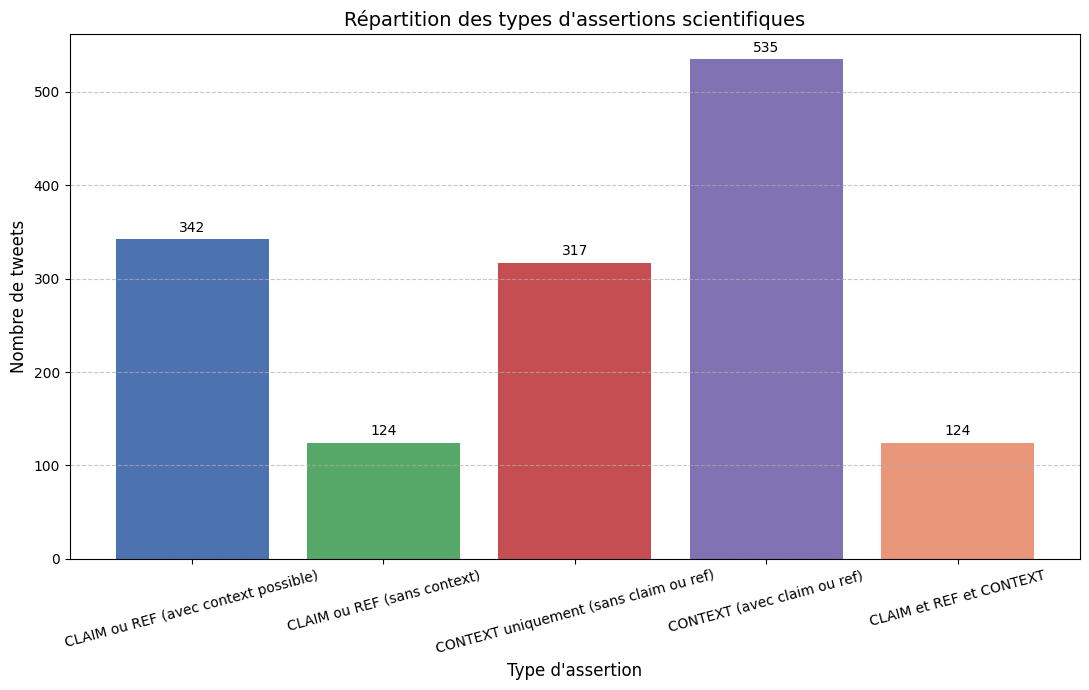


✔️ Équilibrage final :
label
1    342
0    317
Name: count, dtype: int64
🧽 Nettoyage simple (light)...
🔢 Taille TF-IDF : (659, 1388)
➕ Taille features binaires : (659, 3)
📐 Taille finale : (659, 1391)
🧼 Matrice nettoyée : (659, 1037)


In [ ]:

df_sci = pipeline.analyze_data(df)

df_sci = pipeline.create_label(df_sci)

df_sci, text_column = pipeline.preprocess_data(df_sci, use_advanced_cleaning=False)

X_tfidf, X_full, vect = pipeline.vectorize_text(df_sci, use_cleaned=False)

X, _ = pipeline.extract_cleaned_features(X_tfidf, vect)

y = df_sci["label"]
results_df = pipeline.evaluate_models(X, y)

#pipeline.save_best_model()

In [ ]:

df_sci = pipeline.analyze_data(df)

df_sci = pipeline.create_label(df_sci)

df_sci, text_column = pipeline.preprocess_data(df_sci, use_advanced_cleaning=True)

X_tfidf, X_full, vect = pipeline.vectorize_text(df_sci, use_cleaned=True)

X_cleaned, _ = pipeline.extract_cleaned_features(X_tfidf, vect)

y = df_sci["label"]
results_df = pipeline.evaluate_models(X_cleaned, y)

pipeline.save_best_model()


## Data Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import roc_curve, auc
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE
from umap import UMAP

class DataVisualizer:
    def __init__(self):
        pass

    def reduce_dimensions(self, X, method="svd"):
        if method == "svd":
            reducer = TruncatedSVD(n_components=2, random_state=42)
        else:
            reducer = PCA(n_components=2, random_state=42)

        return reducer.fit_transform(X)

    def plot_decision_boundary(self, model, X_2D, y, title):
        h = .02
        x_min, x_max = X_2D[:, 0].min() - 1, X_2D[:, 0].max() + 1
        y_min, y_max = X_2D[:, 1].min() - 1, X_2D[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        model.fit(X_2D, y)
        try:
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        except Exception as e:
            print(f"Erreur: {e}")
            return

        cmap_light = ListedColormap(['#FFCCCC', '#CCCCFF'])
        cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

        plt.figure(figsize=(6, 4))
        plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.3)
        plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
        plt.title(f"Frontière de décision : {title}")
        plt.xlabel("Composante 1")
        plt.ylabel("Composante 2")
        plt.tight_layout()
        plt.show()

    def plot_multiple_boundaries(self, X, y):
        pca = PCA(n_components=2, random_state=42)
        X_vis = pca.fit_transform(X.toarray())
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_vis)

        classifiers = {
            "Logistic Regression": LogisticRegression(),
            "Gaussian NB": GaussianNB(),
            "Decision Tree": DecisionTreeClassifier(),
            "SVM": SVC()
        }

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.ravel()
        colors = ['blue', 'orange']
        markers = ['o', 's']

        for idx, (name, clf) in enumerate(classifiers.items()):
            clf.fit(X_scaled, y)
            accuracy = clf.score(X_scaled, y)

            DecisionBoundaryDisplay.from_estimator(
                clf, X_scaled, cmap=plt.cm.Paired, response_method="predict", alpha=0.8, ax=axes[idx]
            )

            for label, marker, color in zip([0, 1], markers, colors):
                axes[idx].scatter(X_scaled[y == label][:, 0], X_scaled[y == label][:, 1],
                                  c=color, marker=marker, edgecolor='k', label=f"Classe {label}" if idx == 0 else "")

            axes[idx].set_title(f"{name} (Accuracy: {accuracy:.2f})", fontsize=12)
            axes[idx].set_xlabel("PC1")
            axes[idx].set_ylabel("PC2")

        handles = [plt.Line2D([0], [0], marker=markers[i], color='w', markerfacecolor=colors[i], markeredgecolor='k', markersize=10, label=f"Classe {i}") for i in range(2)]
        fig.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()

    def plot_roc_curve(self, y_true, y_scores, model_name="Model"):
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, marker='o', linestyle='-', color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def plot_dimensionality_reduction(self, X, y):
        df_y = pd.Series(y).astype(str)
        X_dense = X.toarray()

        # PCA 2D
        pca = PCA(n_components=2, random_state=0)
        components_2d = pca.fit_transform(X_dense)
        fig_pca_2d = px.scatter(pd.DataFrame(components_2d), x=0, y=1, color=df_y, labels={"color": "Label"})
        fig_pca_2d.update_layout(title='ACP (2D)')
        fig_pca_2d.show()

        # PCA 3D
        pca3 = PCA(n_components=3, random_state=0)
        components_3d = pca3.fit_transform(X_dense)
        fig_pca_3d = px.scatter_3d(pd.DataFrame(components_3d), x=0, y=1, z=2, color=df_y, title='ACP (3D)',
                                   labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'})
        fig_pca_3d.show()

        # TSNE 2D
        tsne2d = TSNE(n_components=2, random_state=0)
        tsne_proj_2d = tsne2d.fit_transform(X_dense)
        fig_tsne_2d = px.scatter(pd.DataFrame(tsne_proj_2d), x=0, y=1, color=df_y, labels={'color': 'Label'})
        fig_tsne_2d.update_layout(title='t-SNE (2D)')
        fig_tsne_2d.show()

        # TSNE 3D
        tsne3d = TSNE(n_components=3, random_state=0)
        tsne_proj_3d = tsne3d.fit_transform(X_dense)
        fig_tsne_3d = px.scatter_3d(pd.DataFrame(tsne_proj_3d), x=0, y=1, z=2, color=df_y, labels={'color': 'Label'})
        fig_tsne_3d.update_layout(title='t-SNE (3D)')
        fig_tsne_3d.show()

        # UMAP 2D
        umap2d = UMAP(n_components=2, init='random', random_state=0)
        umap_proj_2d = umap2d.fit_transform(X_dense)
        fig_umap_2d = px.scatter(pd.DataFrame(umap_proj_2d), x=0, y=1, color=df_y, labels={'color': 'Label'})
        fig_umap_2d.update_layout(title='UMAP (2D)')
        fig_umap_2d.show()

        # UMAP 3D
        umap3d = UMAP(n_components=3, init='random', random_state=0)
        umap_proj_3d = umap3d.fit_transform(X_dense)
        fig_umap_3d = px.scatter_3d(pd.DataFrame(umap_proj_3d), x=0, y=1, z=2, color=df_y, labels={'color': 'Label'})
        fig_umap_3d.update_layout(title='UMAP (3D)')
        fig_umap_3d.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Exemple d'utilisation après vectorisation
visualizer = DataVisualizer()

# Réduction SVD en 2D (sur X_final ou X_cleaned) pour frontière de décision simple
X_2D = visualizer.reduce_dimensions(X_cleaned, method="svd")  # ou "pca"

# Visualisation des frontières, tracer la frontière d’un modèle simple
visualizer.plot_decision_boundary(LogisticRegression(), X_2D, y, "Logistic Regression")

# Plusieurs modèles d’un coup, Tracer 2x2 plusieurs modèles avec PCA
visualizer.plot_multiple_boundaries(X_cleaned, y)

# Courbes interactives PCA/tSNE/UMAP en 2D/3D
visualizer.plot_dimensionality_reduction(X_cleaned, y)


# (optionnel) ROC si on a y_scores (sortie de .predict_proba ou .decision_function)
model = MLPClassifier(max_iter=300, random_state=42)
y_scores = cross_val_predict(model, X, y, cv=skf, method='predict_proba')[:, 1]
visualizer.plot_roc_curve(y, y_scores, model_name="MLP")


## Results Visualization

In [ ]:
plt.figure(figsize=(15, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 4, i)
    sns.barplot(data=results, x='Model', y=metric)
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

In [ ]:
import optuna
import optuna.visualization as vis
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

class HyperparameterTuner:
    def __init__(self):
        self.best_models = {}

    def tune_and_evaluate(self, model_name, model, param_grid, X, y):
        print(f"\n🔍 Recherche d'hyperparamètres pour {model_name}...")
        search = GridSearchCV(model, param_grid=param_grid, scoring='f1', cv=5)
        search.fit(X, y)

        print(f"✅ Meilleurs paramètres {model_name} :", search.best_params_)

        y_pred = cross_val_predict(search.best_estimator_, X, y, cv=5)

        print(f"\n📊 Rapport de classification - {model_name} (validation croisée) :")
        print(classification_report(y, y_pred))

        self.best_models[model_name] = search.best_estimator_

    def tune_all(self, X, y):
        param_svm = {
            'C': [0.01, 0.1, 1, 10]
        }
        self.tune_and_evaluate("SVM (linéaire)", LinearSVC(), param_svm, X, y)

        param_mlp = {
            'hidden_layer_sizes': [(100,), (100,50)],
            'alpha': [0.0001, 0.001],
            'learning_rate_init': [0.001, 0.01]
        }
        self.tune_and_evaluate("MLP", MLPClassifier(max_iter=300, random_state=42), param_mlp, X, y)

        param_nb = {
            'alpha': [0.1, 0.5, 1.0]
        }
        self.tune_and_evaluate("Multinomial NB", MultinomialNB(), param_nb, X, y)

    def get_best_model(self, name):
        return self.best_models.get(name, None)

    def evaluate_model_cv(self, model, X, y, cv=10):
        accs, precs, recalls, f1s = [], [], [], []
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            accs.append(accuracy_score(y_test, y_pred))
            precs.append(precision_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred))
            f1s.append(f1_score(y_test, y_pred))

        print("\n🔬 Résultats avec CV (moyenne ± écart-type):")
        print(f"Accuracy : {np.mean(accs):.3f} ± {np.std(accs):.3f}")
        print(f"Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}")
        print(f"Recall   : {np.mean(recalls):.3f} ± {np.std(recalls):.3f}")
        print(f"F1-score : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")

    def run_optuna(self, X, y, model_choisi):
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

        def objective_svm(trial):
            C = trial.suggest_float("C", 1e-3, 10, log=True)
            clf = LinearSVC(C=C, max_iter=1000)
            scores = cross_val_score(clf, X, y, cv=skf, scoring='f1')
            return scores.mean()

        def objective_svc(trial):
            kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
            params = {
                'C': trial.suggest_float('C', 1e-2, 10, log=True),
                'kernel': kernel,
                'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
            }
            if kernel == 'poly':
                params['degree'] = trial.suggest_int('degree', 2, 5)
            model = SVC(**params)
            scores = cross_val_score(model, X, y, cv=skf, scoring='f1', n_jobs=-1)
            return scores.mean()

        def objective_mlp(trial):
            hidden_layer_sizes = trial.suggest_categorical("hidden_layer_sizes", [(100,), (100, 50), (150,)])
            alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
            learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
            clf = make_pipeline(
                StandardScaler(with_mean=False),
                MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha,
                             learning_rate_init=learning_rate_init, max_iter=300, random_state=42)
            )
            scores = cross_val_score(clf, X, y, cv=skf, scoring='f1')
            return scores.mean()

        def objective_mlp2(trial):
            hidden_layer_sizes = (
                trial.suggest_int('hidden_layer_1', 50, 200),
                trial.suggest_int('hidden_layer_2', 0, 150)
            )
            hidden_layer_sizes = tuple([h for h in hidden_layer_sizes if h > 0])
            clf = make_pipeline(
                StandardScaler(with_mean=False),
                MLPClassifier(
                    hidden_layer_sizes=hidden_layer_sizes,
                    learning_rate_init=trial.suggest_float('learning_rate_init', 0.0001, 0.1, log=True),
                    activation=trial.suggest_categorical('activation', ['relu', 'tanh']),
                    alpha=trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
                    max_iter=300, random_state=42
                )
            )
            scores = cross_val_score(clf, X, y, cv=skf, scoring='f1', n_jobs=-1)
            return scores.mean()

        def objective_nb(trial):
            alpha = trial.suggest_float("alpha", 1e-3, 2.0, log=True)
            clf = MultinomialNB(alpha=alpha)
            scores = cross_val_score(clf, X, y, cv=skf, scoring='f1')
            return scores.mean()
        
        if model_choisi=="svm" :
            
            # SVM
            study_svm = optuna.create_study(direction="maximize")
            study_svm.optimize(objective_svm, n_trials=200)
            print("\n🔍 Best params SVM:", study_svm.best_params)
            print("🥇 Best F1 score SVM:", study_svm.best_value)
            best_svm = LinearSVC(C=study_svm.best_params["C"], random_state=42)
            self.evaluate_model_cv(best_svm, X, y)
            vis.plot_optimization_history(study_svm).show()
            vis.plot_param_importances(study_svm).show()

        if model_choisi=="svc" :

            # SVC
            study_svc = optuna.create_study(direction="maximize")
            study_svc.optimize(objective_svc, n_trials=200)
            params = study_svc.best_params.copy()
            if params['kernel'] != 'poly' and 'degree' in params:
                del params['degree']
            best_svc = SVC(**params)
            print("\n🔍 Best SVC params:", params)
            print("🥇 Best F1 score SVC:", study_svc.best_value)
            self.evaluate_model_cv(best_svc, X, y)
            vis.plot_optimization_history(study_svc).show()
            vis.plot_param_importances(study_svc).show()

        if model_choisi=="mlp1" :

            # MLP (v1)
            study_mlp = optuna.create_study(direction="maximize")
            study_mlp.optimize(objective_mlp, n_trials=50)
            print("\n🔍 Best MLP params:", study_mlp.best_params)
            print("🥇 Best F1 score MLP:", study_mlp.best_value)
            best_mlp = make_pipeline(
                StandardScaler(with_mean=False),
                MLPClassifier(**study_mlp.best_params, max_iter=300, random_state=42)
            )
            self.evaluate_model_cv(best_mlp, X, y)
            vis.plot_optimization_history(study_mlp).show()
            vis.plot_param_importances(study_mlp).show()

        if model_choisi=="mlp2" :

            # MLP (v2)
            study_mlp2 = optuna.create_study(direction="maximize")
            study_mlp2.optimize(objective_mlp2, n_trials=50)
            params = study_mlp2.best_params
            hidden_layer_sizes = []
            if 'hidden_layer_1' in params:
                hidden_layer_sizes.append(params['hidden_layer_1'])
            if 'hidden_layer_2' in params and params['hidden_layer_2'] > 0:
                hidden_layer_sizes.append(params['hidden_layer_2'])
            best_mlp2 = make_pipeline(
                StandardScaler(with_mean=False),
                MLPClassifier(
                    hidden_layer_sizes=tuple(hidden_layer_sizes),
                    learning_rate_init=params['learning_rate_init'],
                    activation=params['activation'],
                    alpha=params['alpha'],
                    max_iter=300,
                    random_state=42
                )
            )
            print("\n🔍 Study 2 - Best MLP params:", params)
            print("🥇 Study 2 - Best F1 score MLP:", study_mlp2.best_value)
            self.evaluate_model_cv(best_mlp2, X, y)
            vis.plot_optimization_history(study_mlp2).show()
            vis.plot_param_importances(study_mlp2).show()

        if model_choisi=="mb" :
            # MultinomialNB
            study_nb = optuna.create_study(direction="maximize")
            study_nb.optimize(objective_nb, n_trials=200)
            print("\n🔍 Best MultinomialNB params:", study_nb.best_params)
            print("🥇 Best F1 score MultinomialNB:", study_nb.best_value)
            best_nb = MultinomialNB(**study_nb.best_params)
            self.evaluate_model_cv(best_nb, X, y)
            vis.plot_optimization_history(study_nb).show()
            vis.plot_param_importances(study_nb).show()


In [ ]:


tuner = HyperparameterTuner()
#tuner.tune_all(X_cleaned, y) 

# Récupérer un modèle pour enchaîner ensuite
#best_mlp = tuner.get_best_model("MLP")

tuner.run_optuna(X_cleaned, y, "mlp1")


In [ ]:
tuner.run_optuna(X_cleaned, y, "mlp2")  # ou X_cleaned selon ta vectorisation


In [ ]:
tuner = HyperparameterTuner()

tuner.run_optuna(X_cleaned, y, "mb") 
